In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
%matplotlib inline

In [78]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':350,
        'noise':0.1,
        'train_size':0.7
        }

# Prepare Data

In [79]:
dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=args['noise'])
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Models
(input size, output size, forward pass)

In [80]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = F.relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [81]:
n_samples = len(train_dataset)
sepc_size = 66
temp_size = 1

layers = []
for layer in range(1,12):
    layers.append({'layer': layer,
                   'model' : Net(input_size=sepc_size, output_size=temp_size)
                   })

# Training Loops

In [82]:
learning_rate = args['lr']
criterion = nn.MSELoss()
num_epochs = args['epochs']

In [83]:
best_losses = []
for layer in layers:
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {layer["layer"]}')
    optimizer = torch.optim.Adam(layer['model'].parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for temp_batch, spec_batch in train_loader:
            spec_train = spec_batch
            temp_train = temp_batch[:,layer['layer']-1].reshape(-1,1)
            
            # forward pass and loss
            temp_pred = layer['model'](spec_train)
            loss = criterion(temp_pred, temp_train)

            # backward pass
            loss.backward()

            # update
            optimizer.step()

            # empty gradients
            optimizer.zero_grad()

        if (epoch+1) % int(num_epochs/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch+1

    best_losses.append(best_loss.item())
    print(f'best loss: {best_loss} in epoch {best_epoch}\n')

Layer 1
epoch: 35, loss = 1141.1201171875
epoch: 70, loss = 801.5457153320312
epoch: 105, loss = 425.1291809082031
epoch: 140, loss = 481.4825744628906
epoch: 175, loss = 671.880126953125
epoch: 210, loss = 239.83615112304688
epoch: 245, loss = 694.97802734375
epoch: 280, loss = 765.5049438476562
epoch: 315, loss = 648.6911010742188
epoch: 350, loss = 348.3504333496094
best loss: 32.01758575439453 in epoch 303

Layer 2
epoch: 35, loss = 285.837890625
epoch: 70, loss = 337.398681640625
epoch: 105, loss = 281.5857849121094
epoch: 140, loss = 196.53878784179688
epoch: 175, loss = 123.41867065429688
epoch: 210, loss = 605.096923828125
epoch: 245, loss = 240.96463012695312
epoch: 280, loss = 167.02749633789062
epoch: 315, loss = 364.0378112792969
epoch: 350, loss = 444.27593994140625
best loss: 10.916149139404297 in epoch 234

Layer 3
epoch: 35, loss = 182.02171325683594
epoch: 70, loss = 119.21846008300781
epoch: 105, loss = 290.2159118652344
epoch: 140, loss = 22.648361206054688
epoch: 17

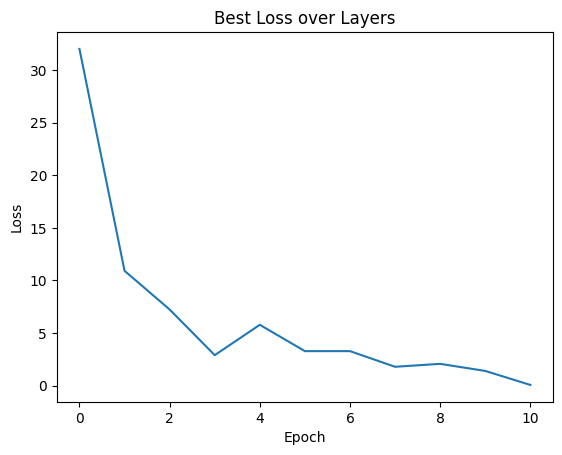

In [84]:
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [85]:
def make_predictions(spec_batch):
    predictions = []
    
    for layer in layers:
        pred = layer['model'](spec_batch)
        predictions.append(pred)

    return predictions

In [88]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual):
    plt.plot(actual, label='actual')
    plt.plot(pred, 'r+', label='predicted')

    plt.title(f"Layer")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

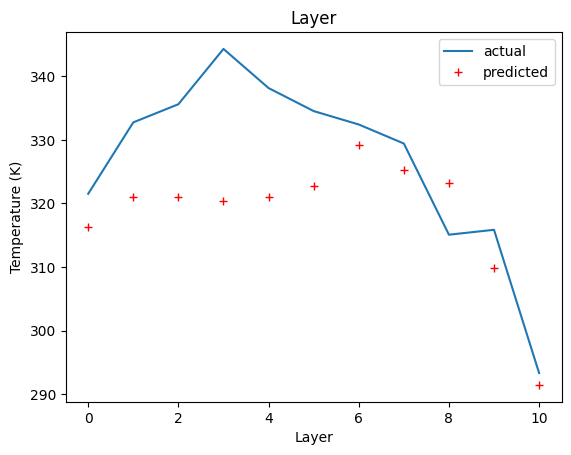

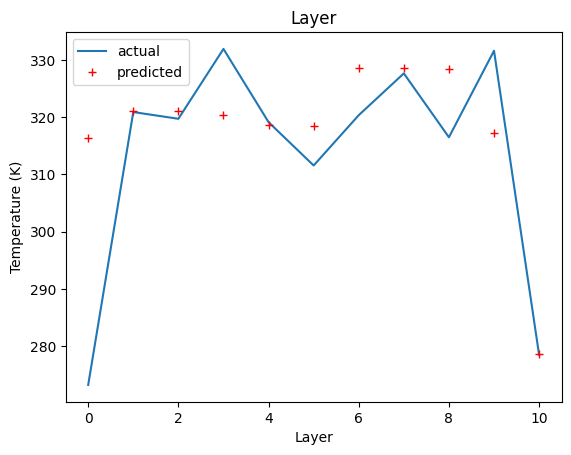

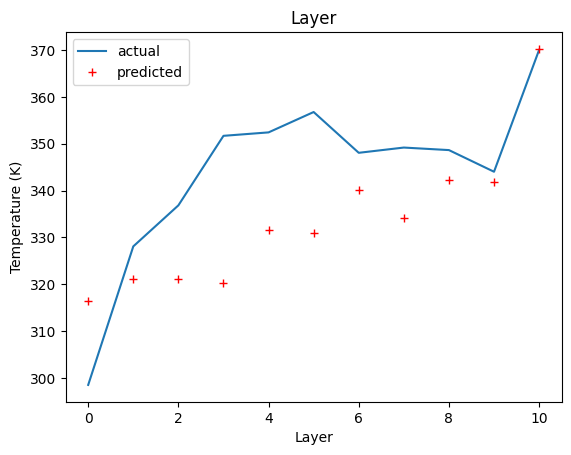

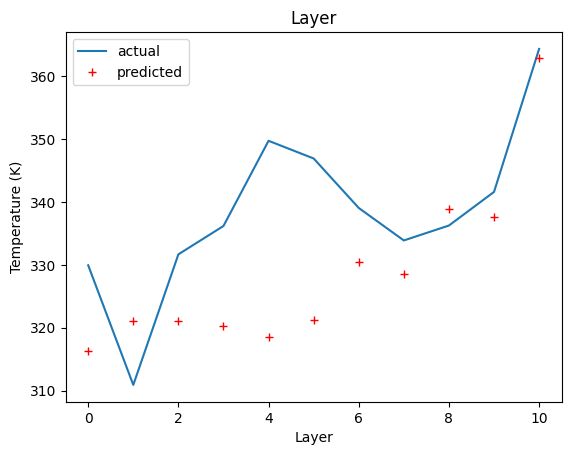

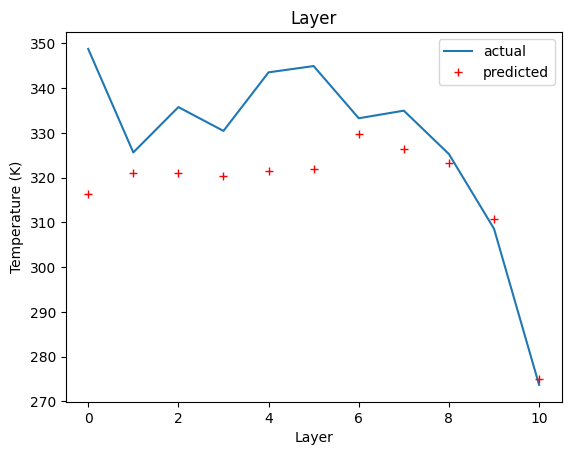

[839.0, 292.0, 174.0, 167.0, 153.0, 143.0, 135.0, 77.0, 52.0, 56.0, 3.0]


In [89]:
layer_loss_total = [0] * 11
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        predictions = make_predictions(spec_batch)

        pred_list = []
        actual_list = []
        index = 0
        for pred in predictions:
            actual = temp_batch[:,index].reshape(-1,1)
            layer_loss_total[index] += criterion(pred, actual).item()
            index += 1
            
            pred_list.append(pred[0].item())
            actual_list.append(actual[0].item())

        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(pred_list, actual_list)         

    average_layer_loss = [x//total_batches for x in layer_loss_total]

print(average_layer_loss)